In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#train : 2022-01-01 ~ 2023-04-04 실제 일별 판매량
#sales : 2022-01-01 ~ 2023-04-04 실제 일별 총 판매금액
#brand : 2022-01-01 ~ 2023-04-04 브랜드의 연관키워드 언급량을 정규화한 일별 데이터
#info : 제품 특성 데이터(Text)
train = pd.read_csv('/root/lg-data/train.csv')
sales = pd.read_csv('/root/lg-data/sales.csv')
info = pd.read_csv('/root/lg-data/product_info.csv')
brand = pd.read_csv('/root/lg-data/brand_keyword_cnt.csv')

지희님 EDA

In [3]:
train_data_category = train.loc[:,:'브랜드']

In [5]:
with open('product_category.txt','w') as f:
    for category1 in train_data_category['대분류'].unique():
        f.write('대분류 '+ category1+'\n')
        train_inner1 = train_data_category[train_data_category['대분류']==category1]
        for category2 in train_inner1['중분류'].unique():
            f.write('└──중분류 '+ category2+'\n')
            train_inner2 = train_inner1[train_inner1['중분류']==category2]
            f.write('   └──소분류 '+ ', '.join(train_inner2['소분류'].unique())+'\n')

중분류 B002-C002-0009 제외 겹치는 분류 없음 -> 유아 관련

B002-C001- : 대분류  
B002-C002- : 중분류  
B002-C003- : 소분류  

### 파생변수
- 5. 세트 구분
- 6. 본품 리필 구분
- 7. 대 소용량 구분
- 8. 향/색 다른 제품 (?)
- 9. 전자제품


In [7]:
info_train = pd.merge(info, train[['제품','대분류','중분류','소분류','브랜드']], how='inner', on='제품')

### 5. 세트 


- 잡곡밥/곤약밥/볶음밥 등 몇 종 구성
- 물티슈 캡형+리필형 몇 종 구성
- 바디클렌저+바디로션 구성 
- 샴푸 + 트리트먼트 구성  
- 등

-> 세트가 의미하는 것들 : 샴푸+트리트먼트 등 함께 사용하는 제품들 + 물티슈 10종 구성 등 대용량 상품 + 30ml 샘플 등이 포함된 기획세트상품

1. 제품특성에 세트라는 단어가 포함되어 있는 경우
2. 리필과 본품이 함께 들어있는 경우

In [128]:
list_5_1 = list(info_train[info_train['제품특성'].str.contains('세트')]['제품'])

In [129]:
list_5_2 = list(info_train[(info_train['제품특성'].str.contains('리필'))&(info_train['제품특성'].str.contains('본품'))]['제품'])

In [130]:
list_5 = list_5_1+list_5_2
len(list_5)

1321

In [131]:
list_5_final = list(set(list_5))
len(list_5_final) 

1299

<고민>

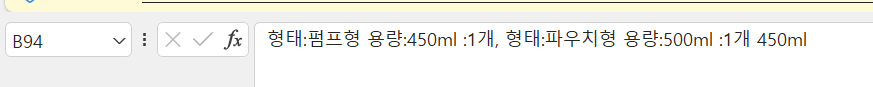

B002-C003-0032 94번행.. 이런 것두 세트같은데.. 본품+리필 조합.. 세트라는 것 어떻게 알아낼지?

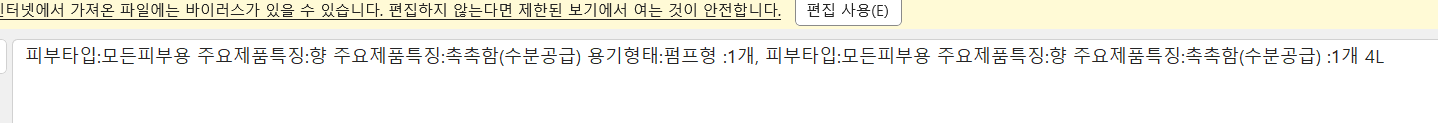

이건 제품 하나? 둘?  
-> 하나같긴 한데.. 이런 info가 많아서 ['용기형태'가 여러 번 나오면 여러 개 한번에 들어있는 세트 제품이다.] 등의 논리를 적용 불가능   
-> 위의 B94같은 제품은 어떻게 확인?

### 6. 본품 리필 구분

'본품'은 포함되지 않고 '리필'만 포함된 제품 1로 표시

In [166]:
info_train[(info_train['제품특성'].str.contains('리필'))&(~info_train['제품특성'].str.contains('본품'))].head()

,제품,제품특성,대분류,중분류,소분류,브랜드
1383,B002-00722-00006,"구성:리필 :1개, 구성:리필 용량:1.3L :1개, 구성:리필 용량:1.3L :1개",B002-C001-0002,B002-C002-0002,B002-C003-0006,B002-00722
1384,B002-01156-00022,형태:고체형 고정방식:비치형 :1개 360 2세대 + 리필 1,B002-C001-0002,B002-C002-0002,B002-C003-0006,B002-01156
1393,B002-01677-00001,"구성:디퓨저 구성:리필 형태:원형 용량:2000ml, 구성:디퓨저 구성:스틱 형태:...",B002-C001-0002,B002-C002-0002,B002-C003-0006,B002-01677
1394,B002-01677-00002,"구성:디퓨저 구성:리필 형태:원형 용량:2000ml, 구성:리필 형태:원형 용량:5...",B002-C001-0002,B002-C002-0002,B002-C003-0006,B002-01677
1398,B002-02044-00001,"구성:디퓨저 구성:스틱 구성:리필 형태:원형 용량:500ml, 구성:디퓨저 구성:스...",B002-C001-0002,B002-C002-0002,B002-C003-0006,B002-02044


In [158]:
list_6 = list(info_train[(info_train['제품특성'].str.contains('리필'))&(~info_train['제품특성'].str.contains('본품'))]['제품'])

In [159]:
len(list_6)

191

<고민>

리필 + 본품 제품인 것들 어떻게 구분? 
- 리필 + 본품이 함께 들어있는 제품이라면 리필에는 포함되면 안 되고, 세트에 포함되어야 함.
- but, info에 본품이란 단어가 들어있지 않으면 리필 vs 리필+본품 함께 구성된 제품이라는 것 구분 불가능

-> 함께 구성된 제품은 우선 세트로 분류 & 세트=1이면 리필 값은 무조건 0으로   
-> 세트 정확하게 구분 필요 -> 로직 추가

### 9. 전자제품

전자제품은 다른 제품들에 비해 상대적으로 오래 사용할 것이란 가설 ex) 전기면도기, 전동칫솔, 샬균기 등

- AA, AAA, 건전지, 배터리, 전원, 충전, 블루투스, USB, 전력 등 info에 포함

In [202]:
df_9 = info_train[info_train['제품특성'].str.contains('AA|AAA|건전지|배터리|전원|충전|블루투스|USB|전력')]

In [184]:
df_9.iloc[0,1] #BCAA 단백질 

'단백질종류:동물성+식물성 단백질성분:농축유청단백질(WPC) 단백질성분:분리대두단백질(ISP) 단백질:12g 중량:50g 개당열량:249kcal :1개, 단백질종류:동물성+식물성 단백질성분:농축유청단백질(WPC) 단백질성분:분리대두단백질(ISP) 단백질:25g 맛:초코 :1개, 단백질종류:동물성+식물성 단백질성분:농축유청단백질(WPC) 단백질성분:분리대두단백질(ISP) 단백질:25g 맛:초코 :1개, 종류_A단백질종류:BCAA 단백질성분:동물성+식물성 단백질성분:농축유청단백질(WPC) 단백질:분리대두단백질(ISP) 맛:24g 중량:초코 개당열량:70g :287kcal, 단백질종류:동물성+식물성 단백질성분:농축유청단백질(WPC) 단백질성분:분리대두단백질(ISP) 단백질:12g 중량:150g 개당열량:249kcal :1개 50g'

In [204]:
df_9.loc[4640,'제품특성'] #충전재

'종류:수유쿠션 충전재:솜 소재:폴리에스터 소재:면 특징:겉감분리 특징:등받이 '

In [205]:
df_9 = info_train[(info_train['제품특성'].str.contains('AA|AAA|건전지|배터리|전원|충전|블루투스|USB|전력'))&
                  (~info_train['제품특성'].str.contains('BCAA|충전재'))]

In [221]:
list_9 = list(df_9['제품'])

<고민>

In [217]:
df_9.loc[631,'제품특성']

'생균:100억 CFU 1일 총 섭취량:1포 제품용량:1개월분 제품타입:분말 섭취횟수:하루 한 번 섭취방법:물과 함께 섭취대상:유아/청소년 주요 기능성(식약처인증):장건강 :1개, 사용부위:페이스용 피부타입:모든피부용 주요제품특징:촉촉함(수분공급) 주요제품특징:흡수력 세부제품특징:부드러운 발림 세부제품특징:화이트닝 세부제품특징:주름케어 세부제품특징:각질케어 용량:50ml(g) :1개, 생균:10억 CFU 1일 총 섭취량:5방울 제품용량:2개월분 제품타입:액상 섭취횟수:하루 한 번 섭취방법:물과 함께 섭취대상:유아/청소년 주요 기능성(식약처인증):장건강 영양소 원료명(식약처고시):비타민D :1개, 품목:파우치 품목:피부미용기 품목:피부마사지기 품목:고주파미용기 품목:제모기 품목:교체용헤드 품목:충전용어댑터 품목:거치대 품목:얼굴마사지기 품목:교체용팁 품목:갈바닉마사지기 품목:레이저제모기 상태표시등:배터리 상태표시등:헤드교환 편의기능:레이저 편의기능:배터리잔량표시 편의기능:스킨센서 편의기능:저출력광선 편의기능:LCD표시창 편의기능:제모 편의기능:피부관리 추가구성:메뉴얼 추가구성:케이스, 용도형태화면:가정용, 생균1일 총 섭취량제품용량제품타입섭취횟수섭취방법섭취대상주요 기능성(식약처인증)영양소 원료명(식약처고시):100억 CFU, 주요소재패턴:면, 중량포장형태:120g, 생균1일 총 섭취량제품용량제품타입섭취횟수섭취방법섭취대상주요 기능성(식약처인증)영양소 원료명(식약처고시):100억 CFU, 생균1일 총 섭취량제품용량제품타입섭취횟수섭취방법섭취대상주요 기능성(식약처인증)영양소 원료명(식약처고시):100억 CFU, 세트구성:바디클렌저 세트구성:바디로션 :1개, 생균1일 총 섭취량제품용량제품타입섭취횟수섭취방법섭취대상주요 기능성(식약처인증)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(식약처고시)영양소 원료명(

[생균:100억 CFU, 품목:교체용헤드 품목:충전용어댑터 품목:거치대 품목:얼굴마사지기 품목:교체용팁 품목:갈바닉마사지기 품목:레이저제모기, 세트구성:바디클렌저 세트구성:바디로션 :1개] 등이 함께 적혀있는데 잘못 입력된 것인지? or 세트상품?   

다른 제품에서도 비슷한 info 다수 목격

### 변수 생성

In [222]:
#혹시 더 효율좋은 코드가 있다면.. 변경 please
for i in range(len(train)):
    if train.loc[i,'제품'] in list_5_final:
        train.loc[i,'세트'] = 1
    else:
        train.loc[i,'세트'] = 0

    if train.loc[i,'제품'] in list_6:
        train.loc[i,'리필'] = 1
    else:
        train.loc[i,'리필'] = 0

    if train.loc[i,'제품'] in list_9:
        train.loc[i,'전자제품'] = 1
    else:
        train.loc[i,'전자제품'] = 0

In [223]:
train['세트'] = train['세트'].astype('int64')
train['리필'] = train['리필'].astype('int64')
train['전자제품'] = train['전자제품'].astype('int64')

In [224]:
train.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04,세트,리필,전자제품
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,1,3,2,0,0,2,0,0,0,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 7&8 
-> 대/중/소분류 같으면서 브랜드 같은 제품들끼리 info 확인 필요  
-> 아직 고민중 info 더 살펴봐야함

In [234]:
info_train[(info_train['소분류']=='B002-C003-0001')]

,제품,제품특성,대분류,중분류,소분류,브랜드
0,B002-03509-00001,제품유형:일반식품 콜라겐 펩타이드:1000mg 종류:어류 분자량:300Da 섭취대상...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03509
1,B002-02376-00001,700mg x 28정,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-02376
2,B002-03735-00001,제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 두 번 1일 총 섭...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03735
3,B002-03735-00003,제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 한 번 1일 총 섭...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03735
4,B002-02769-00001,HCA:900mg 영양소 원료명(식약처고시):비타민B1 영양소 원료명(식약처고시):...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-02769
...,...,...,...,...,...,...
10394,B002-02352-00002,HCA영양소 원료명(식약처고시)1일 총 섭취량제품용량제품타입섭취횟수섭취방법섭취대상주...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-02352
10421,B002-00861-00010,제품유형:일반식품 영양소 원료명(식약처고시)_A종류:비타민C 분자량:어류 섭취대상:...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-00861
10439,B002-01513-00001,제품유형:일반식품 종류:어류 섭취대상:성인남녀 제품타입:정 제품용량:4개월분 섭취횟...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-01513
10443,B002-03642-00001,주요 기능성(식약처인증):체지방 감소 영양소 원료명(식약처고시):비타민A 영양소 원...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03642


In [235]:
info_train[(info_train['소분류']=='B002-C003-0001')&(info_train['브랜드']=='B002-03735')]

,제품,제품특성,대분류,중분류,소분류,브랜드
2,B002-03735-00001,제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 두 번 1일 총 섭...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03735
3,B002-03735-00003,제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 한 번 1일 총 섭...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03735
9596,B002-03735-00006,제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 두 번 1일 총 섭...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03735
10264,B002-03735-00008,제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 한 번 1일 총 섭...,B002-C001-0001,B002-C002-0001,B002-C003-0001,B002-03735


In [241]:
info_train[(info_train['소분류']=='B002-C003-0001')&(info_train['브랜드']=='B002-03735')].iloc[1,1]

'제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 한 번 1일 총 섭취량:1정 제품용량:2개월분 :1개 510mg x 60정'

In [240]:
info_train[(info_train['소분류']=='B002-C003-0001')&(info_train['브랜드']=='B002-03735')].iloc[3,1]

'제품타입:정 섭취방법:물과 함께 섭취대상:성인남녀 섭취횟수:하루 한 번 1일 총 섭취량:1정 제품용량:2개월분 :1개 510mg x 60정'

In [250]:
info_train[(info_train['소분류']=='B002-C003-0015')]

,제품,제품특성,대분류,중분류,소분류,브랜드
1578,B002-01206-00001,종류:유아얼룩제거제 형태:스프레이형 구성:본품 용량:500ml :1개 500g,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-01206
1579,B002-02903-00001,형태:액상형 구성:본품 용량:8000ml(g) :1개 8L,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02903
1580,B002-02903-00002,형태:액상형 구성:리필 용량:2000ml(g) :1개 2L,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02903
1581,B002-02903-00003,"형태:액상형 구성:리필 용량:2000ml(g) :1개, 구성:본품 용량:2200ml...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02903
1582,B002-02903-00004,"세탁기유형:일반,드럼겸용 형태:시트형 구성:본품 :1개, 형태:액상형 구성:본품 용...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02903
...,...,...,...,...,...,...
10188,B002-00391-00001,"세탁기유형:일반,드럼겸용 형태:캡슐형 성분:무형광증백제 성분:무색소 :1개, 세탁기...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-00391
10249,B002-02043-00001,형태:액상형 구성:본품 용량:2000ml(g) :1개 2L,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02043
10268,B002-01371-00013,"세탁기유형:일반,드럼겸용 형태:캡슐형 구성:본품+리필 특징:고농축 특징:향균효과 성...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-01371
10354,B002-01063-00044,"세탁기유형형태구성용량특징:일반세탁용, 세탁기유형형태구성용량특징:일반세탁용, 세탁기유...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-01063


In [251]:
info_train[(info_train['소분류']=='B002-C003-0015')&(info_train['브랜드']=='B002-02280')]

,제품,제품특성,대분류,중분류,소분류,브랜드
1587,B002-02280-00001,"형태:시트형 구성:본품 :1개, 형태:시트형 구성:본품 용량:370ml(g) :1개...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1588,B002-02280-00002,"형태:시트형 구성:본품 :1개, 형태:시트형 구성:본품 용량:205ml(g) :1개...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1589,B002-02280-00003,형태:시트형 구성:본품 용량:370ml(g) :1개 36매,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1590,B002-02280-00006,세탁기유형:드럼세탁용 형태:액상형 구성:본품 용량:3000ml(g) 성분:무형광증백...,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1591,B002-02280-00007,세탁기유형:일반세탁용 형태:액상형 구성:리필 용량:2000ml(g) 성분:무형광증백...,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1592,B002-02280-00008,"형태:액상형 구성:리필 용량:2000ml(g) :1개, 형태:액상형 구성:리필 :1...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1593,B002-02280-00009,"형태:액상형 구성:리필 용량:2000ml(g) :1개, 형태:액상형 구성:리필 :1...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1594,B002-02280-00010,세탁기유형:일반세탁용 형태:액상형 구성:리필 용량:2000ml(g) 성분:무형광증백...,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1595,B002-02280-00011,세탁기유형:일반세탁용 형태:액상형 구성:리필 용량:2000ml(g) 성분:무형광증백...,B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280
1596,B002-02280-00012,"형태:가루형 구성:본품 용량:7000ml(g) 세탁기유형:일반,드럼겸용 :1개, 형...",B002-C001-0002,B002-C002-0003,B002-C003-0015,B002-02280


In [254]:
info_train[(info_train['소분류']=='B002-C003-0015')&(info_train['브랜드']=='B002-02280')].iloc[4,1]

'세탁기유형:일반세탁용 형태:액상형 구성:리필 용량:2000ml(g) 성분:무형광증백제 :1개, 형태:액상형 구성:본품 용량:3000ml(g) :1개, 세탁기유형:일반세탁용 형태:액상형 구성:본품 용량:4700ml(g) 성분:무형광증백제 :1개, 세탁기유형:드럼세탁용 형태:액상형 구성:본품 용량:3000ml(g) 성분:무형광증백제 :1개, 세탁기유형:드럼세탁용 형태:액상형 구성:본품 용량:3000ml(g) 성분:무형광증백제 :1개, 형태:액상형 구성:리필 용량:2000ml(g) :1개, 형태:액상형 구성:본품 용량:3000ml(g) :1개, 형태:액상형 구성:리필 :1개, 형태:액상형 구성:리필 :2개 3L'

In [256]:
info_train[(info_train['소분류']=='B002-C003-0015')&(info_train['브랜드']=='B002-02280')].iloc[3,1]

'세탁기유형:드럼세탁용 형태:액상형 구성:본품 용량:3000ml(g) 성분:무형광증백제 :1개, 세탁기유형:드럼세탁용 형태:액상형 구성:본품 용량:3000ml(g) 성분:무형광증백제 :1개, 형태:액상형 구성:리필 용량:2000ml(g) :1개, 형태:액상형 구성:본품 용량:3000ml(g) :1개, 형태:액상형 구성:리필 :1개, 세탁기유형:일반세탁용 형태:액상형 구성:리필 용량:2000ml(g) 성분:무형광증백제 :1개, 형태:액상형 구성:본품 용량:3000ml(g) :1개, 세탁기유형:일반세탁용 형태:액상형 구성:본품 용량:4700ml(g) 성분:무형광증백제 :1개, 형태:액상형 구성:리필 :2개 3L'

In [258]:
info_train[(info_train['소분류']=='B002-C003-0015')&(info_train['브랜드']=='B002-02280')].loc[9439,'제품특성']

'세탁기유형:일반,드럼겸용 형태:가루형 구성:리필 용량:3000ml(g) 특징:실내건조 성분:무형광증백제 :1개 3kg'

In [259]:
info_train[(info_train['소분류']=='B002-C003-0015')&(info_train['브랜드']=='B002-02280')].loc[9566,'제품특성']

'세탁기유형:일반,드럼겸용 형태:가루형 구성:리필 용량:3000ml(g) 특징:실내건조 성분:무형광증백제 :1개, 세탁기유형:일반,드럼겸용 형태:가루형 용량:6000ml(g) 특징:실내건조 :1개 6kg'